## 로지스틱 회귀 모델(다중 클래스 분류)

In [1]:
# 필요 라이브러리 선언
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# PDF 출력
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

### 데이터 준비

In [3]:
# 학습용 데이터 준비
from sklearn.datasets import load_iris
iris = load_iris()
x_org, y_org = iris.data, iris.target

# 입력 데이터에 관해서는 sepal length(0)와 petal length(2)만을 추출
x_select = x_org[:,[0,2]]
print('원래 데이터', x_select.shape, y_org.shape)

원래 데이터 (150, 2) (150,)


### 학습 데이터의 산점도 표시

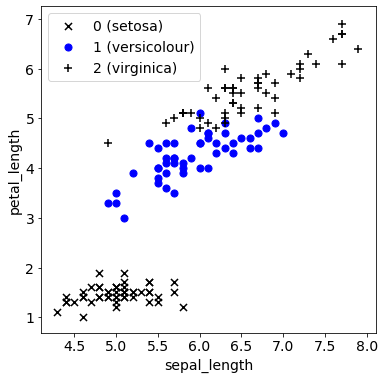

In [4]:
# 산점도 표시
x_t0 = x_select[y_org == 0]
x_t1 = x_select[y_org == 1]
x_t2 = x_select[y_org == 2]
plt.figure(figsize=(6,6))
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length', fontsize=14)
plt.ylabel('petal_length', fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.show()

### 데이터 전처리

In [5]:
# 더미 변수를 추가
x_all = np.insert(x_select, 0, 1.0, axis=1)

In [6]:
# y의 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, categories='auto')
y_work = np.c_[y_org]
y_all_one = ohe.fit_transform(y_work)
print('오리지널', y_org.shape)
print('2차원화', y_work.shape)
print('원핫 인코딩', y_all_one.shape)

오리지널 (150,)
2차원화 (150, 1)
원핫 인코딩 (150, 3)


In [7]:
# 학습 데이터와 검증 데이터를 분할
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, y_train_one, y_test_one = train_test_split(
    x_all, y_org, y_all_one, train_size=75, test_size=75, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, 
    y_train_one.shape, y_test_one.shape)

(75, 3) (75, 3) (75,) (75,) (75, 3) (75, 3)


In [8]:
print('입력 데이터(x)')
print(x_train[:5,:])

입력 데이터(x)
[[1.  6.3 4.7]
 [1.  7.  4.7]
 [1.  5.  1.6]
 [1.  6.4 5.6]
 [1.  6.3 5. ]]


In [9]:
print('정답값(y)')
print(y_train[:5])

정답값(y)
[1 1 0 2 2]


In [10]:
print('정답값(원핫 인코딩)')
print(y_train_one[:5,:])

정답값(원핫 인코딩)
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


### 학습용 변수 설정

In [11]:
# 학습 대상의 선택
x, yt = x_train, y_train_one

### 예측함수

In [12]:
# 소프트맥스 함수 (9.7.3)
def softmax(x):
    x = x.T
    x_max = x.max(axis=0)
    x = x - x_max
    w = np.exp(x)
    return (w / w.sum(axis=0)).T

In [13]:
# 예측값 계산 (9.7.1), (9.7.2)
def pred(x, W):
    return softmax(x @ W)

### 평가

In [14]:
# 교차 엔트로피 함수 (9.5.1)
def cross_entropy(yt, yp):
    return -np.mean(np.sum(yt * np.log(yp), axis=1))

In [15]:
# 모델을 평가하는 함수
from sklearn.metrics import accuracy_score

def evaluate(x_test, y_test, y_test_one, W):
    
    # 예측값 계산(확률값)
    yp_test_one = pred(x_test, W)
    
    # 확률값에서 예측 클래스(0, 1, 2)를 도출
    yp_test = np.argmax(yp_test_one, axis=1)
    
    # 손실함수 값 계산
    loss = cross_entropy(y_test_one, yp_test_one)
    
    # 정확도 산출
    score = accuracy_score(y_test, yp_test)
    return loss, score 

### 초기화 처리

In [16]:
# 초기화 처리

# 표본 수
M = x.shape[0]
# 입력 차원 수(더미 변수를 포함)
D = x.shape[1]
# 분류 대상 클래스 수
N = yt.shape[1]

# 반복 횟수
iters = 10000

# 학습률
alpha = 0.01

# 가중치 행렬의 초기 설정(모두가 1)
W = np.ones((D, N)) 

# 평가 결과 기록
history = np.zeros((0, 3))

### 주요 처리

In [17]:
# 주요 처리
for k in range(iters):
    
    # 예측값 계산 (9.7.1), (9.7.2)
    yp = pred(x, W)
    
    # 오차 계산 (9.7.4)
    yd = yp - yt

    # 가중치 업데이트 (9.7.5)
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_one, W)
        history = np.vstack((history,
            np.array([k, loss, score])))
        print("epoch = %d loss = %f score = %f" 
            % (k, loss, score))

epoch = 0 loss = 1.092628 score = 0.266667
epoch = 10 loss = 1.064035 score = 0.266667
epoch = 20 loss = 1.033466 score = 0.266667
epoch = 30 loss = 1.002645 score = 0.266667
epoch = 40 loss = 0.973510 score = 0.266667
epoch = 50 loss = 0.946309 score = 0.386667
epoch = 60 loss = 0.920978 score = 0.560000
epoch = 70 loss = 0.897402 score = 0.600000
epoch = 80 loss = 0.875452 score = 0.613333
epoch = 90 loss = 0.855005 score = 0.626667
epoch = 100 loss = 0.835942 score = 0.626667
epoch = 110 loss = 0.818152 score = 0.626667
epoch = 120 loss = 0.801532 score = 0.626667
epoch = 130 loss = 0.785986 score = 0.626667
epoch = 140 loss = 0.771424 score = 0.640000
epoch = 150 loss = 0.757767 score = 0.653333
epoch = 160 loss = 0.744941 score = 0.680000
epoch = 170 loss = 0.732877 score = 0.706667
epoch = 180 loss = 0.721513 score = 0.760000
epoch = 190 loss = 0.710795 score = 0.786667
epoch = 200 loss = 0.700670 score = 0.786667
epoch = 210 loss = 0.691092 score = 0.800000
epoch = 220 loss = 0.

epoch = 1910 loss = 0.360355 score = 0.946667
epoch = 1920 loss = 0.359721 score = 0.946667
epoch = 1930 loss = 0.359090 score = 0.946667
epoch = 1940 loss = 0.358463 score = 0.946667
epoch = 1950 loss = 0.357840 score = 0.946667
epoch = 1960 loss = 0.357220 score = 0.946667
epoch = 1970 loss = 0.356603 score = 0.946667
epoch = 1980 loss = 0.355990 score = 0.946667
epoch = 1990 loss = 0.355381 score = 0.946667
epoch = 2000 loss = 0.354775 score = 0.946667
epoch = 2010 loss = 0.354172 score = 0.946667
epoch = 2020 loss = 0.353572 score = 0.946667
epoch = 2030 loss = 0.352976 score = 0.946667
epoch = 2040 loss = 0.352383 score = 0.946667
epoch = 2050 loss = 0.351793 score = 0.946667
epoch = 2060 loss = 0.351207 score = 0.946667
epoch = 2070 loss = 0.350623 score = 0.946667
epoch = 2080 loss = 0.350043 score = 0.946667
epoch = 2090 loss = 0.349466 score = 0.946667
epoch = 2100 loss = 0.348892 score = 0.946667
epoch = 2110 loss = 0.348321 score = 0.946667
epoch = 2120 loss = 0.347753 score

epoch = 4050 loss = 0.274522 score = 0.960000
epoch = 4060 loss = 0.274266 score = 0.960000
epoch = 4070 loss = 0.274012 score = 0.960000
epoch = 4080 loss = 0.273758 score = 0.960000
epoch = 4090 loss = 0.273505 score = 0.960000
epoch = 4100 loss = 0.273253 score = 0.960000
epoch = 4110 loss = 0.273002 score = 0.960000
epoch = 4120 loss = 0.272751 score = 0.960000
epoch = 4130 loss = 0.272502 score = 0.960000
epoch = 4140 loss = 0.272253 score = 0.960000
epoch = 4150 loss = 0.272005 score = 0.960000
epoch = 4160 loss = 0.271758 score = 0.960000
epoch = 4170 loss = 0.271511 score = 0.960000
epoch = 4180 loss = 0.271266 score = 0.960000
epoch = 4190 loss = 0.271021 score = 0.960000
epoch = 4200 loss = 0.270777 score = 0.960000
epoch = 4210 loss = 0.270534 score = 0.960000
epoch = 4220 loss = 0.270291 score = 0.960000
epoch = 4230 loss = 0.270050 score = 0.960000
epoch = 4240 loss = 0.269809 score = 0.960000
epoch = 4250 loss = 0.269569 score = 0.960000
epoch = 4260 loss = 0.269330 score

epoch = 6350 loss = 0.231978 score = 0.960000
epoch = 6360 loss = 0.231844 score = 0.960000
epoch = 6370 loss = 0.231711 score = 0.960000
epoch = 6380 loss = 0.231578 score = 0.960000
epoch = 6390 loss = 0.231445 score = 0.960000
epoch = 6400 loss = 0.231313 score = 0.960000
epoch = 6410 loss = 0.231181 score = 0.960000
epoch = 6420 loss = 0.231049 score = 0.960000
epoch = 6430 loss = 0.230918 score = 0.960000
epoch = 6440 loss = 0.230786 score = 0.960000
epoch = 6450 loss = 0.230656 score = 0.960000
epoch = 6460 loss = 0.230525 score = 0.960000
epoch = 6470 loss = 0.230395 score = 0.960000
epoch = 6480 loss = 0.230265 score = 0.960000
epoch = 6490 loss = 0.230135 score = 0.960000
epoch = 6500 loss = 0.230006 score = 0.960000
epoch = 6510 loss = 0.229877 score = 0.960000
epoch = 6520 loss = 0.229748 score = 0.960000
epoch = 6530 loss = 0.229620 score = 0.960000
epoch = 6540 loss = 0.229492 score = 0.960000
epoch = 6550 loss = 0.229364 score = 0.960000
epoch = 6560 loss = 0.229236 score

epoch = 8520 loss = 0.208898 score = 0.960000
epoch = 8530 loss = 0.208813 score = 0.960000
epoch = 8540 loss = 0.208729 score = 0.960000
epoch = 8550 loss = 0.208645 score = 0.960000
epoch = 8560 loss = 0.208560 score = 0.960000
epoch = 8570 loss = 0.208477 score = 0.960000
epoch = 8580 loss = 0.208393 score = 0.960000
epoch = 8590 loss = 0.208309 score = 0.960000
epoch = 8600 loss = 0.208226 score = 0.960000
epoch = 8610 loss = 0.208142 score = 0.960000
epoch = 8620 loss = 0.208059 score = 0.960000
epoch = 8630 loss = 0.207976 score = 0.960000
epoch = 8640 loss = 0.207893 score = 0.960000
epoch = 8650 loss = 0.207811 score = 0.960000
epoch = 8660 loss = 0.207728 score = 0.960000
epoch = 8670 loss = 0.207646 score = 0.960000
epoch = 8680 loss = 0.207563 score = 0.960000
epoch = 8690 loss = 0.207481 score = 0.960000
epoch = 8700 loss = 0.207399 score = 0.960000
epoch = 8710 loss = 0.207317 score = 0.960000
epoch = 8720 loss = 0.207236 score = 0.960000
epoch = 8730 loss = 0.207154 score

### 결과 확인

In [18]:
# 손실함수의 값과 정확도 점검
print ( '[초기 상태] 손실함수: %f, 정확도: %f'
    % (history[0,1], history[0,2]))
print( '[최종 상태] 손실함수: %f, 정확도: %f'
    % (history[-1,1], history[-1,2]))

[초기 상태] 손실함수: 1.092628, 정확도: 0.266667
[최종 상태] 손실함수: 0.197948, 정확도: 0.960000


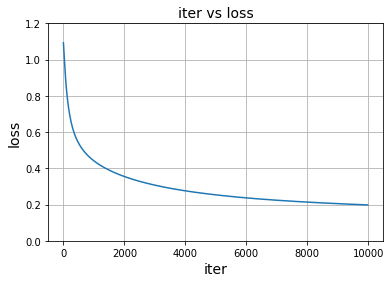

In [19]:
# 학습 곡선 표시 (손실 함수)
plt.plot(history[:,0], history[:,1])
plt.grid()
plt.ylim(0,1.2)
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('iter vs loss', fontsize=14)
plt.show()

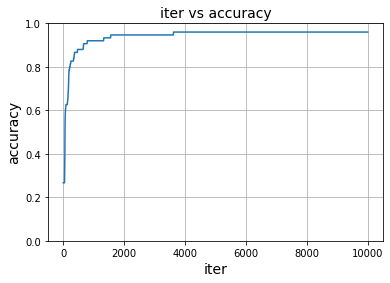

In [20]:
# 학습 곡선 표시 (정밀도)
plt.plot(history[:,0], history[:,2])
plt.ylim(0,1)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()

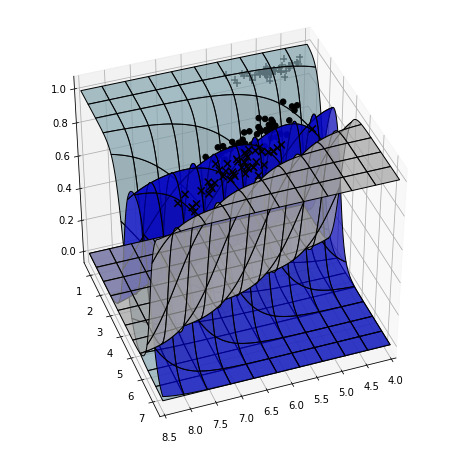

In [21]:
# 3차원 표시
from mpl_toolkits.mplot3d import Axes3D
x1 = np.linspace(4, 8.5, 100)
x2 = np.linspace(0.5, 7.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xxx = np.array([np.ones(xx1.ravel().shape), 
    xx1.ravel(), xx2.ravel()]).T
pp = pred(xxx, W)
c0 = pp[:,0].reshape(xx1.shape)
c1 = pp[:,1].reshape(xx1.shape)
c2 = pp[:,2].reshape(xx1.shape)
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx1, xx2, c0, color='lightblue', 
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c1, color='blue', 
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c2, color='lightgrey', 
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.scatter(x_t0[:,0], x_t0[:,1], 1, s=50, alpha=1, marker='+', c='k')
ax.scatter(x_t1[:,0], x_t1[:,1], 1, s=30, alpha=1, marker='o', c='k')
ax.scatter(x_t2[:,0], x_t2[:,1], 1, s=50, alpha=1, marker='x', c='k')
ax.set_xlim(4,8.5)
ax.set_ylim(0.5,7.5)
ax.view_init(elev=40, azim=70)

In [22]:
# 평가
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 테스트 데이터로 예측값 계산
yp_test_one = pred(x_test, W)
yp_test = np.argmax(yp_test_one, axis=1)

# 정확도 계산
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, yp_test)
print('accuracy: %f' % score)

# 혼동행렬의 표시
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, yp_test))
print(classification_report(y_test, yp_test))

accuracy: 0.960000
[[27  0  0]
 [ 0 20  0]
 [ 0  3 25]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.87      1.00      0.93        20
           2       1.00      0.89      0.94        28

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.97      0.96      0.96        75



# 입력 변수를 4차원으로 변경

In [23]:
# 더미 변수를 추가
x_all2 = np.insert(x_org, 0, 1.0, axis=1)

In [24]:
# 학습 데이터와 검증 데이터로 분할
from sklearn.model_selection import train_test_split

x_train2, x_test2, y_train, y_test,\
y_train_one, y_test_one = train_test_split(
    x_all2, y_org, y_all_one, train_size=75, 
    test_size=75, random_state=123)
print(x_train2.shape, x_test2.shape, 
    y_train.shape, y_test.shape, 
    y_train_one.shape, y_test_one.shape)

(75, 5) (75, 5) (75,) (75,) (75, 3) (75, 3)


In [25]:
print('입력 데이터(x)')
print(x_train2[:5,:])

입력 데이터(x)
[[1.  6.3 3.3 4.7 1.6]
 [1.  7.  3.2 4.7 1.4]
 [1.  5.  3.  1.6 0.2]
 [1.  6.4 2.8 5.6 2.1]
 [1.  6.3 2.5 5.  1.9]]


In [26]:
# 학습 대상의 선택
x, yt, x_test = x_train2, y_train_one, x_test2

In [27]:
# 초기화 처리

# 표본 수
M = x.shape[0]
# 입력 차원 수(더미 변수를 포함)
D = x.shape[1]
# 분류 대상 클래스 수
N = yt.shape[1]

# 반복 횟수
iters = 10000

# 학습률
alpha = 0.01

# 가중치 행렬의 초기 설정(모두가 1)
W = np.ones((D, N)) 

# 평가 결과 기록
history = np.zeros((0, 3))

In [28]:
# 주요 처리(4차원 버전)
for k in range(iters):
    
    # 예측값 계산 (9.7.1), (9.7.2)
    yp = pred(x, W)
    
    # 오차 계산 (9.7.4)
    yd = yp - yt

    # 가중치 업데이트 (9.7.5)
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_one, W)
        history = np.vstack((history, np.array([k, loss, score])))
        print("epoch = %d loss = %f score = %f" % (k, loss, score))

epoch = 0 loss = 1.091583 score = 0.266667
epoch = 10 loss = 1.041711 score = 0.266667
epoch = 20 loss = 0.988501 score = 0.266667
epoch = 30 loss = 0.939962 score = 0.573333
epoch = 40 loss = 0.897037 score = 0.626667
epoch = 50 loss = 0.859177 score = 0.626667
epoch = 60 loss = 0.825724 score = 0.626667
epoch = 70 loss = 0.796070 score = 0.626667
epoch = 80 loss = 0.769683 score = 0.653333
epoch = 90 loss = 0.746103 score = 0.653333
epoch = 100 loss = 0.724936 score = 0.693333
epoch = 110 loss = 0.705850 score = 0.746667
epoch = 120 loss = 0.688561 score = 0.760000
epoch = 130 loss = 0.672832 score = 0.760000
epoch = 140 loss = 0.658461 score = 0.786667
epoch = 150 loss = 0.645275 score = 0.786667
epoch = 160 loss = 0.633131 score = 0.786667
epoch = 170 loss = 0.621903 score = 0.813333
epoch = 180 loss = 0.611485 score = 0.813333
epoch = 190 loss = 0.601788 score = 0.840000
epoch = 200 loss = 0.592731 score = 0.840000
epoch = 210 loss = 0.584248 score = 0.880000
epoch = 220 loss = 0.

epoch = 1870 loss = 0.280610 score = 0.960000
epoch = 1880 loss = 0.279963 score = 0.960000
epoch = 1890 loss = 0.279321 score = 0.960000
epoch = 1900 loss = 0.278683 score = 0.960000
epoch = 1910 loss = 0.278049 score = 0.960000
epoch = 1920 loss = 0.277419 score = 0.960000
epoch = 1930 loss = 0.276793 score = 0.960000
epoch = 1940 loss = 0.276171 score = 0.960000
epoch = 1950 loss = 0.275553 score = 0.960000
epoch = 1960 loss = 0.274939 score = 0.960000
epoch = 1970 loss = 0.274329 score = 0.960000
epoch = 1980 loss = 0.273722 score = 0.960000
epoch = 1990 loss = 0.273120 score = 0.960000
epoch = 2000 loss = 0.272521 score = 0.960000
epoch = 2010 loss = 0.271927 score = 0.960000
epoch = 2020 loss = 0.271335 score = 0.960000
epoch = 2030 loss = 0.270748 score = 0.960000
epoch = 2040 loss = 0.270164 score = 0.960000
epoch = 2050 loss = 0.269584 score = 0.960000
epoch = 2060 loss = 0.269007 score = 0.960000
epoch = 2070 loss = 0.268434 score = 0.960000
epoch = 2080 loss = 0.267865 score

epoch = 3920 loss = 0.201129 score = 0.960000
epoch = 3930 loss = 0.200898 score = 0.960000
epoch = 3940 loss = 0.200668 score = 0.960000
epoch = 3950 loss = 0.200439 score = 0.960000
epoch = 3960 loss = 0.200211 score = 0.960000
epoch = 3970 loss = 0.199983 score = 0.960000
epoch = 3980 loss = 0.199757 score = 0.960000
epoch = 3990 loss = 0.199531 score = 0.960000
epoch = 4000 loss = 0.199306 score = 0.960000
epoch = 4010 loss = 0.199083 score = 0.960000
epoch = 4020 loss = 0.198860 score = 0.960000
epoch = 4030 loss = 0.198638 score = 0.960000
epoch = 4040 loss = 0.198416 score = 0.960000
epoch = 4050 loss = 0.198196 score = 0.960000
epoch = 4060 loss = 0.197976 score = 0.960000
epoch = 4070 loss = 0.197758 score = 0.960000
epoch = 4080 loss = 0.197540 score = 0.960000
epoch = 4090 loss = 0.197323 score = 0.960000
epoch = 4100 loss = 0.197106 score = 0.960000
epoch = 4110 loss = 0.196891 score = 0.960000
epoch = 4120 loss = 0.196676 score = 0.960000
epoch = 4130 loss = 0.196463 score

epoch = 5990 loss = 0.167118 score = 0.960000
epoch = 6000 loss = 0.167002 score = 0.960000
epoch = 6010 loss = 0.166886 score = 0.960000
epoch = 6020 loss = 0.166770 score = 0.960000
epoch = 6030 loss = 0.166654 score = 0.960000
epoch = 6040 loss = 0.166539 score = 0.960000
epoch = 6050 loss = 0.166424 score = 0.960000
epoch = 6060 loss = 0.166310 score = 0.960000
epoch = 6070 loss = 0.166195 score = 0.960000
epoch = 6080 loss = 0.166082 score = 0.960000
epoch = 6090 loss = 0.165968 score = 0.960000
epoch = 6100 loss = 0.165855 score = 0.960000
epoch = 6110 loss = 0.165742 score = 0.960000
epoch = 6120 loss = 0.165629 score = 0.960000
epoch = 6130 loss = 0.165517 score = 0.960000
epoch = 6140 loss = 0.165405 score = 0.960000
epoch = 6150 loss = 0.165293 score = 0.960000
epoch = 6160 loss = 0.165182 score = 0.960000
epoch = 6170 loss = 0.165070 score = 0.960000
epoch = 6180 loss = 0.164960 score = 0.960000
epoch = 6190 loss = 0.164849 score = 0.960000
epoch = 6200 loss = 0.164739 score

epoch = 8140 loss = 0.147851 score = 0.960000
epoch = 8150 loss = 0.147783 score = 0.960000
epoch = 8160 loss = 0.147714 score = 0.960000
epoch = 8170 loss = 0.147646 score = 0.960000
epoch = 8180 loss = 0.147577 score = 0.960000
epoch = 8190 loss = 0.147509 score = 0.960000
epoch = 8200 loss = 0.147441 score = 0.960000
epoch = 8210 loss = 0.147373 score = 0.960000
epoch = 8220 loss = 0.147305 score = 0.960000
epoch = 8230 loss = 0.147238 score = 0.960000
epoch = 8240 loss = 0.147170 score = 0.960000
epoch = 8250 loss = 0.147103 score = 0.960000
epoch = 8260 loss = 0.147036 score = 0.960000
epoch = 8270 loss = 0.146969 score = 0.960000
epoch = 8280 loss = 0.146902 score = 0.960000
epoch = 8290 loss = 0.146835 score = 0.960000
epoch = 8300 loss = 0.146769 score = 0.960000
epoch = 8310 loss = 0.146702 score = 0.960000
epoch = 8320 loss = 0.146636 score = 0.960000
epoch = 8330 loss = 0.146570 score = 0.960000
epoch = 8340 loss = 0.146504 score = 0.960000
epoch = 8350 loss = 0.146438 score

In [29]:
print(history.shape)

(1000, 3)


In [30]:
# 손실함수의 값과 정확도 점검
print ( '[초기 상태] 손실함수: %f, 정확도: %f'
    % (history[0,1], history[0,2]))
print( '[최종 상태] 손실함수: %f, 정확도: %f'
    % (history[-1,1], history[-1,2]))

[초기 상태] 손실함수: 1.091583, 정확도: 0.266667
[최종 상태] 손실함수: 0.137235, 정확도: 0.960000


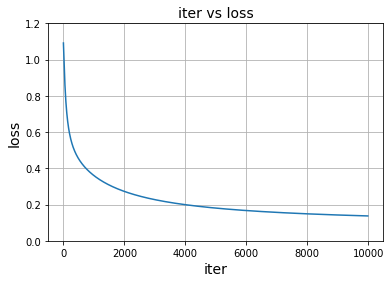

In [31]:
# 학습 곡선 표시 (손실 함수)
plt.plot(history[:,0], history[:,1])
plt.ylim(0,1.2)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('iter vs loss', fontsize=14)
plt.show()

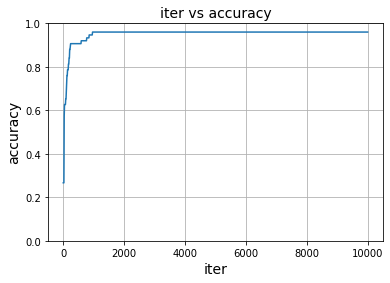

In [32]:
# 학습 곡선 표시 (정밀도)
plt.plot(history[:,0], history[:,2])
plt.ylim(0,1)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()